In [41]:
import tensorflow as tf
import numpy as np
from PIL import Image
import  matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,MaxPooling2D, Flatten, Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.applications.vgg19 import preprocess_input

In [51]:
def pre(input_image):
    input_image = input_image.resize((224, 224))  # Resize the image to 224x224 (VGG19 input size)
    input_array = np.array(input_image.convert('RGB'), dtype=np.float32)  # Convert to RGB and float32
    input_array = np.expand_dims(input_array, axis=0)  # Add batch dimension
    input_array = preprocess_input(input_array)  # Normalize the image for VGG19
    return input_array
image_path = "content-path"
image = Image.open(image_path)
image=pre(image)
image_path = "style-path"
style = Image.open(image_path)
style=pre(style)

In [3]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [52]:
f_l=base_model.get_layer("block1_conv1")
s_l1=base_model.get_layer("block1_conv1")
s_l2=base_model.get_layer("block2_conv1")
s_l3=base_model.get_layer("block3_conv1")
s_l4=base_model.get_layer("block4_conv1")
s_l5=base_model.get_layer("block5_conv1")
for layer in base_model.layers:
    layer.trainable=False


In [38]:
extracted_model=tf.keras.Model(inputs=base_model.input,outputs=[f_l.output,s_l1.output,s_l2.output,s_l3.output,s_l4.output,s_l5.output])

In [6]:
def compute_gram_matrix(image_tensor):

    H, W, C = image_tensor.shape

    
    flattened = tf.reshape(image_tensor, shape=(-1, C))  

    
    gram_matrix = tf.matmul(flattened, flattened, transpose_a=True)  
    return gram_matrix

In [7]:
def contentLoss(content,generated):
    return 0.5*tf.reduce_mean(tf.square(content - generated))


In [8]:
def styleLoss(content,generated):
    content_gram=compute_gram_matrix(content)
    generated_gram=compute_gram_matrix(generated)
    return tf.reduce_mean(tf.square(content_gram - generated_gram))


In [9]:
def total_loss(content_loss,generated_loss,a,b):
    return a*content_loss+b*generated_loss

1 2.5534262e+19
2 1.6289099e+19
3 1.2955865e+19
4 1.250689e+19
5 1.1713555e+19
6 1.0281528e+19
7 8.955229e+18
8 7.8952137e+18
9 7.072713e+18
10 6.393874e+18
11 5.835967e+18
12 5.3694255e+18
13 4.992325e+18
14 4.658361e+18
15 4.3378834e+18
16 4.0160055e+18
17 3.7231204e+18
18 3.4613245e+18
19 3.224856e+18
20 3.007122e+18
21 2.8059366e+18
22 2.6215425e+18
23 2.4500734e+18
24 2.2886546e+18
25 2.1361599e+18
26 1.9931826e+18
27 1.8608172e+18
28 1.7388288e+18
29 1.6263905e+18
30 1.5229216e+18
31 1.4285676e+18
32 1.3416271e+18
33 1.2618942e+18
34 1.1884848e+18
35 1.1228143e+18
36 1.06233e+18
37 1.0075e+18
38 9.578901e+17
39 9.126979e+17
40 8.714886e+17
41 8.333768e+17
42 7.986864e+17
43 7.669564e+17
44 7.376276e+17
45 7.1079276e+17
46 6.856746e+17
47 6.623459e+17
48 6.404935e+17
49 6.1967555e+17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-279.2949..254.80061].


50 6.0010946e+17


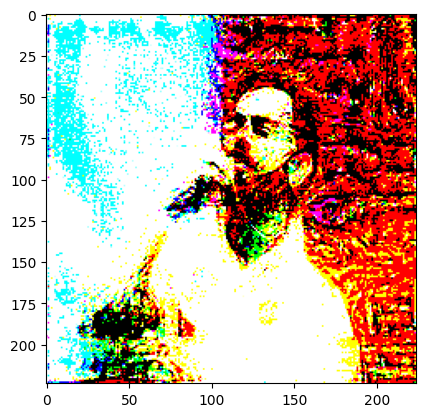

In [53]:
iterations = 50
n_iter = 0


image = tf.cast(image, tf.float32)  
canvas = tf.Variable(image,dtype=tf.float32)
canvas = tf.cast(canvas, tf.float32)  
style = tf.cast(style, tf.float32) 
opt = tf.keras.optimizers.Adam(learning_rate=7.0,beta_1=0.9,beta_2=0.999)

while n_iter < iterations:
    with tf.GradientTape() as tape:
        concatinated_img = tf.concat([image, canvas,style], axis=0)
        op=extracted_model(concatinated_img)
        content=op[0]
        styles1=op[1]
        styles2=op[2]
        styles3=op[3]
        styles4=op[4]
        styles5=op[5]
        style_loss1=styleLoss(styles1[2],styles1[1])
        style_loss2=styleLoss(styles2[2],styles2[1])
        style_loss3=styleLoss(styles3[2],styles3[1])
        style_loss4=styleLoss(styles4[2],styles4[1])
        style_loss5=styleLoss(styles5[2],styles5[1])
        total_style_loss=(style_loss1+style_loss2+style_loss3+style_loss4+style_loss5)/5
        content_loss=contentLoss(content[0],content[1])
        total_lost=total_loss(content_loss,total_style_loss,1,1e3)
        

    gradients = tape.gradient(total_lost, canvas)
    
    opt.apply_gradients([(gradients, canvas)])
    


    n_iter += 1
    print(n_iter,total_lost.numpy())
plt.imshow(canvas[0])
        

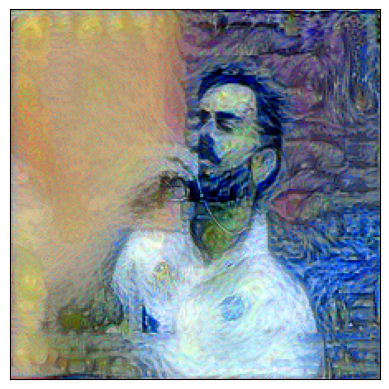

In [54]:

def deprocess(img):
	if isinstance(img, tf.Tensor):
		img = img.numpy()        
	img[:, :, 0] += 103.939
	img[:, :, 1] += 116.779
	img[:, :, 2] += 123.68
	img = img[:, :, ::-1]
	img = np.clip(img, 0, 255).astype('uint8')
	return img


def display_image(image):
	if len(image.shape) == 4:
		image = np.squeeze(image, axis=0)
	img = deprocess(image)
	plt.grid(False)
	plt.xticks([])
	plt.yticks([])
	plt.imshow(img)
	return
ans=display_image(canvas[0])
